In [1]:
import numpy as np
import os
import csv
import json
#
import matplotlib as mpl
import matplotlib.pyplot as plt
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [2]:
# csv_root = '/home/benson516/m1_result_converter/S6_result_20210902_093738_new_eyeOpening_all/converted_results/'
# # csv_label_file = 'eye_status_label_tri_state.csv'
# csv_label_file = 'eye_status_label_tri_state_relabeled.csv'
# csv_predict_file = 'calibrated_eyeOpening_20210902.csv'
#
# csv_root = '/home/benson516/m1_result_converter/S6_result_20210903_184310_new_eyeOpening_inner_product_IRv0.5/converted_results/'
# # csv_label_file = 'eye_status_label_tri_state.csv'
# csv_label_file = 'eye_status_label_tri_state_relabeled.csv'
# csv_predict_file = 'S6_GT-C0-001-L1-V1.10.csv'
#
csv_root = '/home/benson516/m1_result_converter/S6_result_20210913_124113_LM2_v0.02_2/converted_results/'
csv_label_file = 'eye_status_label_tri_state_relabeled.csv'
csv_predict_file = 'S6_GT-C0-001-L1-V1.10.csv'


csv_label_path = os.path.join(csv_root, csv_label_file)
csv_predict_path = os.path.join(csv_root, csv_predict_file)
print(csv_label_path)
print(csv_predict_path)

/home/benson516/m1_result_converter/S6_result_20210913_124113_LM2_v0.02_2/converted_results/eye_status_label_tri_state_relabeled.csv
/home/benson516/m1_result_converter/S6_result_20210913_124113_LM2_v0.02_2/converted_results/S6_GT-C0-001-L1-V1.10.csv


In [3]:
# Label
label_left_list = list()
label_right_list = list()
with open(csv_label_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row["left"])
        label_left_list.append( int(row["left"]) )
        label_right_list.append( int(row["right"]) )
print(len(label_left_list))
print(len(label_right_list))

5810
5810


In [4]:
# Predict: eyeOpening
yv_left_list = list()
yv_right_list = list()
with open(csv_predict_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # print(row["leftEyelidOpening"])
        yv_left_list.append(  float(row["leftEyelidOpening"]) )
        yv_right_list.append( float(row["rightEyelidOpening"]) )
print(len(yv_left_list))
print(len(yv_right_list))

5810
5810


In [5]:
# Filter the half-opening class
keep_id_list_left  = [_idx for _idx in range(len(label_left_list)) if label_left_list[_idx] != 1]
keep_id_list_right = [_idx for _idx in range(len(label_right_list)) if label_right_list[_idx] != 1]

label_left_list  = [ _c for _idx, _c in enumerate(label_left_list) if _idx in keep_id_list_left]
yv_left_list     = [ _v for _idx, _v in enumerate(yv_left_list) if _idx in keep_id_list_left]
label_right_list = [ _c for _idx, _c in enumerate(label_right_list) if _idx in keep_id_list_right]
yv_right_list    = [ _v for _idx, _v in enumerate(yv_right_list) if _idx in keep_id_list_right]

In [6]:
label_left = np.array(label_left_list)
label_right = np.array(label_right_list)
yv_left = np.array(yv_left_list)
yv_right = np.array(yv_right_list)
#
mono_data_size = len(yv_left_list)

In [7]:
# Combine left and right
# label_class = np.array(label_left_list + label_right_list)
# Open
label_open = np.array(label_left_list + label_right_list) == 2
yv_opening = np.array(yv_left_list + yv_right_list)
# Close
lebel_close = np.array(label_left_list + label_right_list) == 0
yv_close = (-1) * np.array(yv_left_list + yv_right_list)

# Simple Prediction by Thresholding

In [8]:
# The threshold
v_threshold = 0.57 # 0.63 # 0.6 # 0.39

In [9]:
# Create class prediction
yc_open = (yv_opening > v_threshold)
yc_close = np.logical_not(yc_open)

In [10]:
# Positive: Open
confusion_matrix(label_open, yc_open)

array([[ 303,   42],
       [  42, 9728]])

In [11]:
# Positive: Close
CM_close = confusion_matrix(lebel_close, yc_close)
print(CM_close)

[[9728   42]
 [  42  303]]


In [12]:
# P: close
TN = CM_close[0,0]
TP = CM_close[1,1]
FN = CM_close[1,0]
FP = CM_close[0,1]

In [13]:
precision_score(lebel_close, yc_close)

0.8782608695652174

In [14]:
recall_score(lebel_close, yc_close)

0.8782608695652174

In [15]:
# False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(FPR)

0.004298874104401228


In [16]:
# Close: Find FN elements
FN_left_idx  = [_idx                    for _idx in range(lebel_close.shape[0]) if (lebel_close[_idx]) and (not yc_close[_idx]) and (_idx < mono_data_size)]
FN_right_idx = [(_idx - mono_data_size) for _idx in range(lebel_close.shape[0]) if (lebel_close[_idx]) and (not yc_close[_idx]) and (_idx >= mono_data_size)]
print(len(FN_left_idx))
print(FN_left_idx)
print(len(FN_right_idx))
print(FN_right_idx)

34
[188, 372, 373, 506, 512, 513, 514, 1841, 1842, 2038, 3256, 3834, 3835, 3838, 3849, 3866, 4013, 4121, 4123, 4261, 4262, 4264, 4265, 4286, 4288, 4438, 4508, 4584, 4587, 4662, 4664, 4805, 4806, 4840]
8
[188, 3837, 4162, 4447, 4448, 4676, 4817, 4818]


In [17]:
# Close: Find FP elements
FP_left_idx  = [_idx                    for _idx in range(lebel_close.shape[0]) if (not lebel_close[_idx]) and (yc_close[_idx]) and (_idx < mono_data_size)]
FP_right_idx = [(_idx - mono_data_size) for _idx in range(lebel_close.shape[0]) if (not lebel_close[_idx]) and (yc_close[_idx]) and (_idx >= mono_data_size)]
print(len(FP_left_idx))
print(FP_left_idx)
print(len(FP_right_idx))
print(FP_right_idx)

9
[426, 529, 534, 736, 879, 1185, 3638, 3832, 3833]
33
[374, 389, 394, 395, 398, 399, 400, 402, 404, 405, 426, 427, 428, 429, 430, 526, 527, 528, 529, 530, 531, 532, 533, 534, 539, 542, 555, 736, 3884, 3899, 4135, 4166, 4868]


In [18]:
# Close: Find FP elements except the (class == 1) ones (half-open)
FP_clear_left_idx  = [_idx for _idx in FP_left_idx if label_left[_idx] != 1]
FP_clear_right_idx = [_idx for _idx in FP_right_idx if label_right[_idx] != 1]
print(len(FP_clear_left_idx))
print(FP_clear_left_idx)
print(len(FP_clear_right_idx))
print(FP_clear_right_idx)

9
[426, 529, 534, 736, 879, 1185, 3638, 3832, 3833]
33
[374, 389, 394, 395, 398, 399, 400, 402, 404, 405, 426, 427, 428, 429, 430, 526, 527, 528, 529, 530, 531, 532, 533, 534, 539, 542, 555, 736, 3884, 3899, 4135, 4166, 4868]


# Precision-recall Curve

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(lebel_close, yv_close)
neg_thresholds = -1.0 * thresholds

In [20]:
target_recall = 0.9 # 0.94209 # 0.9 # 0.7
precision_at_target = precisions[np.argmax(recalls <= target_recall)]
threshold_at_target = thresholds[np.argmax(recalls <= target_recall)]
neg_threshold_at_target = -1.0 * threshold_at_target
print(precision_at_target)
print(neg_threshold_at_target)

0.8516483516483516
0.5987


In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([min(thresholds[0], thresholds[-1]), max(thresholds[0], thresholds[-1]), 0, 1.05]) # Not shown

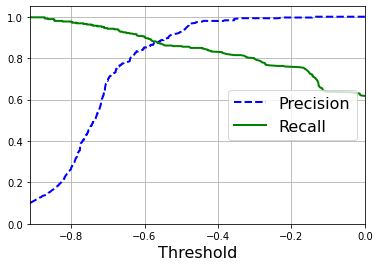

In [22]:
# Threshold for reversed scale
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

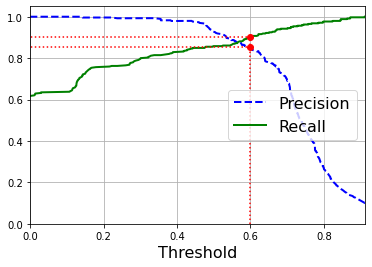

In [23]:
# Threshold for original scale
plot_precision_recall_vs_threshold(precisions, recalls, neg_thresholds)
#
plt.plot([neg_threshold_at_target, neg_threshold_at_target], [0., max(target_recall, precision_at_target)], "r:")
plt.plot([-5, neg_threshold_at_target], [target_recall, target_recall], "r:")             # Not shown
plt.plot([-5, neg_threshold_at_target], [precision_at_target, precision_at_target], "r:") # Not shown
plt.plot([neg_threshold_at_target], [target_recall], "ro")                                # Not shown
plt.plot([neg_threshold_at_target], [precision_at_target], "ro")                          # Not shown

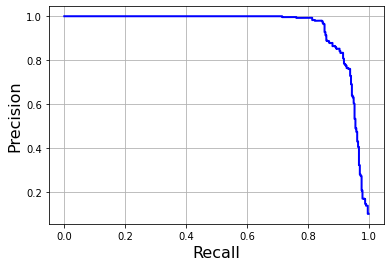

In [24]:
# plt.plot(recalls, precisions)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    # plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plot_precision_vs_recall(precisions, recalls)

# The ROC Curve

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(lebel_close, yv_close)

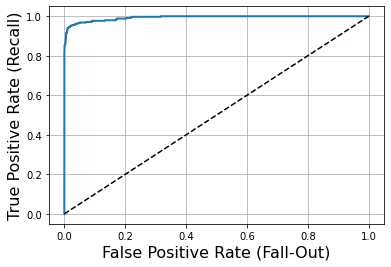

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    # plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    
plot_roc_curve(fpr, tpr)
plt.show()